In [64]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [65]:
def generate(string): 
    a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
    b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])
    c = np.array([[1, -4, -1],[0,-2,-1],[0,3,1]])
    d = np.array([[1, 0, 1],[2, 1, 3],[-3,0,2]])

    maxMats = 50
    dataPoints = 1000
    prevMat = -1


    for j in range(dataPoints):
        nextMat = random.randint(0,3)
        if nextMat == 0: 
            mat = a
            prevMat = 0
        elif nextMat == 1:
            mat = b
            prevMat = 1
        elif nextMat == 2: 
            mat = c
            prevMat = 2
        else: 
            mat = d
            prevMat = 3
        numOfMatrices = random.randint(1, maxMats)
        for i in range(numOfMatrices): 
            nextMat = random.randint(0,3)
            if (prevMat != 2 and nextMat == 0):
                mat = np.matmul(a, mat)
                prevMat = nextMat
            elif (prevMat != 3 and nextMat == 1):
                mat = np.matmul(b, mat)
                prevMat = nextMat
            elif (prevMat != 0 and nextMat == 2):
                mat = np.matmul(c, mat)
                prevMat = nextMat
            elif (prevMat != 1 and nextMat == 3): 
                mat = np.matmul(d,mat)
                prevMat = nextMat
        if j == 0: 
            df = pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]], columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])
        else: 
            df = pd.concat([df, pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]],columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])])
# mat[0][0] = mat[0][0]  % 7
# mat [0][1] = mat[0][1]  % 7
# mat[0][2] = mat[0][2]  % 7
# mat [1][0] = mat[1][0]  % 7
# mat [1][1] = mat[1][1]  % 7
# mat [1][1] = mat[1][1]  % 7
    df.to_csv(string, index = False)


In [66]:
generate('matrices_train.csv')
generate('matrices_test.csv')

In [67]:
# code adapted from ChatGPT

# Define your neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.step1 = nn.Linear(9, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 4, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = SimpleModel()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item
        
        # Print the average loss for this epoch
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [68]:
df = pd.read_csv("matrices_train.csv")

In [69]:
just_input = df.drop('last', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())

In [70]:
desired_output = torch.tensor(df['last'].tolist(), dtype=torch.float32).long()

/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_69131/3944430184.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 1.4797329902648926
Epoch [1/500], Loss: 1.4797
total loss: 1.4557037353515625
Epoch [2/500], Loss: 1.4557
total loss: 1.432576298713684
Epoch [3/500], Loss: 1.4326
total loss: 1.4061295986175537
Epoch [4/500], Loss: 1.4061
total loss: 1.4028993844985962
Epoch [5/500], Loss: 1.4029
total loss: 1.412110447883606
Epoch [6/500], Loss: 1.4121
total loss: 1.4094330072402954
Epoch [7/500], Loss: 1.4094
total loss: 1.402095913887024
Epoch [8/500], Loss: 1.4021
total loss: 1.393117070198059
Epoch [9/500], Loss: 1.3931
total loss: 1.382114052772522
Epoch [10/500], Loss: 1.3821
total loss: 1.3789311647415161
Epoch [11/500], Loss: 1.3789
total loss: 1.3816736936569214
Epoch [12/500], Loss: 1.3817
total loss: 1.3828213214874268
Epoch [13/500], Loss: 1.3828
total loss: 1.383528709411621
Epoch [14/500], Loss: 1.3835
total loss: 1.3820322751998901
Epoch [15/500], Loss: 1.3820
total loss: 1.3787821531295776
Epoch [16/500], Loss: 1.3788
total loss: 1.377754807472229
Epoch [17/500], Loss: 1.3

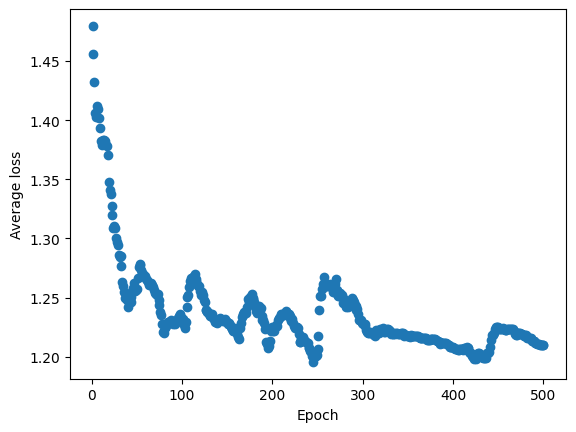

In [73]:
# Train the model
trained_model = train_model(input_data, desired_output, 500, learning_rate=0.001, viz_accuracy=True)

In [74]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)

    predicted_classes = torch.argmax(test_output, dim=1)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [75]:
test_df = pd.read_csv("matrices_test.csv")
just_input_test = test_df.drop('last', axis=1)
input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['last'].tolist(), dtype=torch.float32).long()

In [76]:
test_model(trained_model, input_data_test, desired_output)

/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_69131/875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.515999972820282